In [ ]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 20.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [45]:
# -------------------------------
# Data Loading & Preprocessing
# -------------------------------
data = pd.read_csv('AQI_prediction_dataset.csv')
data = data.drop(columns=['Date'])
target_column = 'AQI'
X = data.drop(columns=[target_column])
y = data[target_column]


In [46]:
# Train-test split (preserving time order)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [47]:
# Standardize features and target
sc = StandardScaler()
sc_target = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
y_train_scaled = sc_target.fit_transform(y_train.values.reshape(-1, 1))
X_test_scaled = sc.transform(X_test)
y_test_scaled = sc_target.transform(y_test.values.reshape(-1, 1))


In [48]:
# Convert to tensors and reshape to (batch_size, seq_length, num_features)
X_train_tensor = torch.Tensor(X_train_scaled).unsqueeze(1)  # seq_length = 1
y_train_tensor = torch.Tensor(y_train_scaled)
X_test_tensor  = torch.Tensor(X_test_scaled).unsqueeze(1)
y_test_tensor  = torch.Tensor(y_test_scaled)


In [ ]:
# -------------------------------
# Model 1: Single LSTM layer, one FC layer + output
# -------------------------------

In [49]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size)
        output, (hn, cn) = self.lstm(x, (h0, c0))
        # Use last hidden state (reshape if needed)
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [ ]:
# -------------------------------
# Model 2: Two LSTM layers, one FC layer + output; ReLU after LSTM & FC
# -------------------------------

In [50]:
class LSTM2(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, seq_length):
        super(LSTM2, self).__init__()
        # Two LSTM layers (num_layers=2)
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=2, batch_first=True)
        # One FC layer and an output layer (two dense layers)
        self.fc = nn.Linear(hidden_size, 128)
        self.out = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.randn(2, x.size(0), self.hidden_size)
        c0 = torch.randn(2, x.size(0), self.hidden_size)
        output, (hn, cn) = self.lstm(x, (h0, c0))
        # Use the last hidden state from the final LSTM layer
        out = self.relu(hn[-1])
        out = self.fc(out)
        out = self.relu(out)
        out = self.out(out)
        return out

In [ ]:
# -------------------------------
# Model 3: Two LSTM layers, two FC layers and an output layer; ReLU after each layer
# -------------------------------

In [51]:
class LSTM3(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, fc_hidden_size, seq_length):
        super(LSTM3, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, fc_hidden_size)
        self.fc2 = nn.Linear(fc_hidden_size, fc_hidden_size)
        self.out = nn.Linear(fc_hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.randn(2, x.size(0), self.hidden_size)
        c0 = torch.randn(2, x.size(0), self.hidden_size)
        output, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.relu(hn[-1])
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.out(out)
        return out

In [ ]:
# -------------------------------
# Model 4: Model 3 with Dropout (dropout rate = 0.5)
# -------------------------------

In [52]:
class LSTM4(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, fc_hidden_size, seq_length, dropout_rate=0.5):
        super(LSTM4, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, fc_hidden_size)
        self.fc2 = nn.Linear(fc_hidden_size, fc_hidden_size)
        self.out = nn.Linear(fc_hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.randn(2, x.size(0), self.hidden_size)
        c0 = torch.randn(2, x.size(0), self.hidden_size)
        output, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.relu(hn[-1])
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.out(out)
        return out


In [53]:
# -------------------------------
# Training Function
# -------------------------------
def train_model(model, X_train, y_train, num_epochs=200, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} Loss: {loss.item():.5f}")
    return losses

In [54]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).numpy()
    # Inverse-transform predictions and true values
    predictions_inv = sc_target.inverse_transform(predictions)
    y_actual = sc_target.inverse_transform(y_test.numpy())
    r2 = r2_score(y_actual, predictions_inv)
    mae = mean_absolute_error(y_actual, predictions_inv)
    rmse = np.sqrt(mean_squared_error(y_actual, predictions_inv))
    mape = np.mean(np.abs((y_actual - predictions_inv) / y_actual)) * 100
    return r2, mae, rmse, mape, predictions_inv, y_actual

In [55]:
# -------------------------------
# Hyperparameters & Model Instantiation
# -------------------------------
num_classes = 1
input_size = X_train_tensor.shape[2]  # should be 13
seq_length = 1

# For Models 1 & 2, we use hidden_size=2
hidden_size_m1_m2 = 2

# For Models 3 & 4, we add an extra FC layer so we use a larger hidden size in FC layers
fc_hidden_size = 128
hidden_size_m3_m4 = 2  # you can also experiment with larger hidden sizes here if desired


In [56]:
# Instantiate each model
model1 = LSTM1(num_classes, input_size, hidden_size_m1_m2, num_layers=1, seq_length=seq_length)
model2 = LSTM2(num_classes, input_size, hidden_size_m1_m2, seq_length=seq_length)
model3 = LSTM3(num_classes, input_size, hidden_size_m3_m4, fc_hidden_size, seq_length=seq_length)
model4 = LSTM4(num_classes, input_size, hidden_size_m3_m4, fc_hidden_size, seq_length=seq_length, dropout_rate=0.5)

models = {
    "Model 1 (1 LSTM, 1 FC + output)": model1,
    "Model 2 (2 LSTM, 1 FC + output)": model2,
    "Model 3 (2 LSTM, 2 FC + output)": model3,
    "Model 4 (Model 3 + Dropout 0.5)": model4
}

In [57]:
# -------------------------------
# Train and Evaluate All Models
# -------------------------------
num_epochs = 200
lr = 0.001
results = {}
losses_dict = {}

for name, model in models.items():
    print(f"\nTraining {name} ...")

    # Train the model and store the loss curve
    losses = train_model(model, X_train_tensor, y_train_tensor, num_epochs=200, lr=lr)
    losses_dict[name] = losses

    # Evaluate the model and unpack all evaluation metrics
    r2, mae, rmse, mape, preds, y_actual = evaluate_model(model, X_test_tensor, y_test_tensor)

    # Store all metrics in a dictionary for this model
    results[name] = {"r2": r2, "mae": mae, "rmse": rmse, "mape": mape}

    print(f"{name} Metrics:")
    print(f"R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}%")


Training Model 1 (1 LSTM, 1 FC + output) ...
Epoch 20/200 Loss: 0.97814
Epoch 40/200 Loss: 0.94913
Epoch 60/200 Loss: 0.91193
Epoch 80/200 Loss: 0.86249
Epoch 100/200 Loss: 0.83279
Epoch 120/200 Loss: 0.79303
Epoch 140/200 Loss: 0.78602
Epoch 160/200 Loss: 0.76563
Epoch 180/200 Loss: 0.73872
Epoch 200/200 Loss: 0.72992
Model 1 (1 LSTM, 1 FC + output) Metrics:
R²: 0.3275, MAE: 12.7975, RMSE: 16.3858, MAPE: 16.9798%

Training Model 2 (2 LSTM, 1 FC + output) ...
Epoch 20/200 Loss: 1.00045
Epoch 40/200 Loss: 1.00062
Epoch 60/200 Loss: 0.99671
Epoch 80/200 Loss: 0.99459
Epoch 100/200 Loss: 0.99184
Epoch 120/200 Loss: 0.97678
Epoch 140/200 Loss: 0.95894
Epoch 160/200 Loss: 0.93026
Epoch 180/200 Loss: 0.90493
Epoch 200/200 Loss: 0.88200
Model 2 (2 LSTM, 1 FC + output) Metrics:
R²: -0.2701, MAE: 17.8052, RMSE: 22.5188, MAPE: 25.6358%

Training Model 3 (2 LSTM, 2 FC + output) ...
Epoch 20/200 Loss: 1.00054
Epoch 40/200 Loss: 1.00015
Epoch 60/200 Loss: 1.00012
Epoch 80/200 Loss: 1.00048
Epoch 1

In [58]:
# -------------------------------
# Compare Model Performance (All Metrics)
# -------------------------------
print("\n--- Model Comparison ---")
for name, metrics in results.items():
    print(f"{name}: R² = {metrics['r2']:.4f}, MAE = {metrics['mae']:.4f}, "
          f"RMSE = {metrics['rmse']:.4f}, MAPE = {metrics['mape']:.4f}%")


--- Model Comparison ---
Model 1 (1 LSTM, 1 FC + output): R² = 0.3275, MAE = 12.7975, RMSE = 16.3858, MAPE = 16.9798%
Model 2 (2 LSTM, 1 FC + output): R² = -0.2701, MAE = 17.8052, RMSE = 22.5188, MAPE = 25.6358%
Model 3 (2 LSTM, 2 FC + output): R² = -0.3739, MAE = 18.7767, RMSE = 23.4206, MAPE = 27.0287%
Model 4 (Model 3 + Dropout 0.5): R² = -0.4401, MAE = 19.9341, RMSE = 23.9790, MAPE = 28.9175%


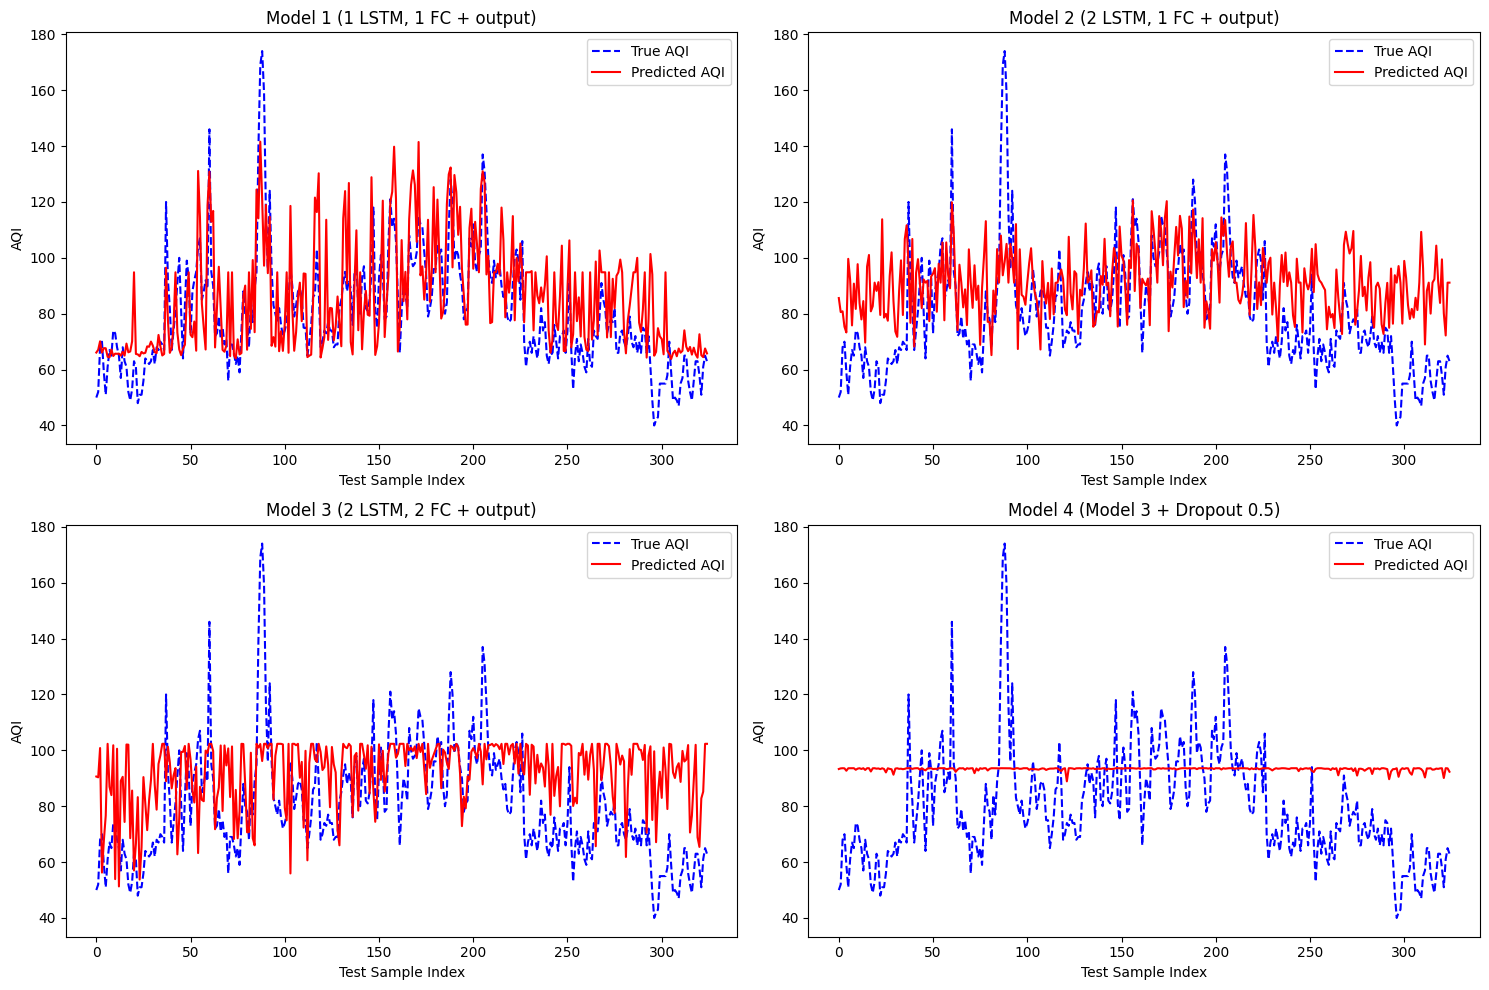

In [59]:
# -------------------------------
# Visualize predictions for each model
# Plot Actual vs Predicted AQI for Each Model
# -------------------------------
plt.figure(figsize=(15, 10))

# Loop over the models dictionary
for i, (name, model) in enumerate(models.items()):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        preds = model(X_test_tensor).numpy()
    # Inverse-transform the predictions and true targets
    preds_inv = sc_target.inverse_transform(preds)
    y_actual = sc_target.inverse_transform(y_test_tensor.numpy())

    plt.subplot(2, 2, i + 1)
    plt.plot(y_actual, label='True AQI', color='blue', linestyle='--')
    plt.plot(preds_inv, label='Predicted AQI', color='red')
    plt.title(name)
    plt.xlabel('Test Sample Index')
    plt.ylabel('AQI')
    plt.legend()

plt.tight_layout()
plt.show()

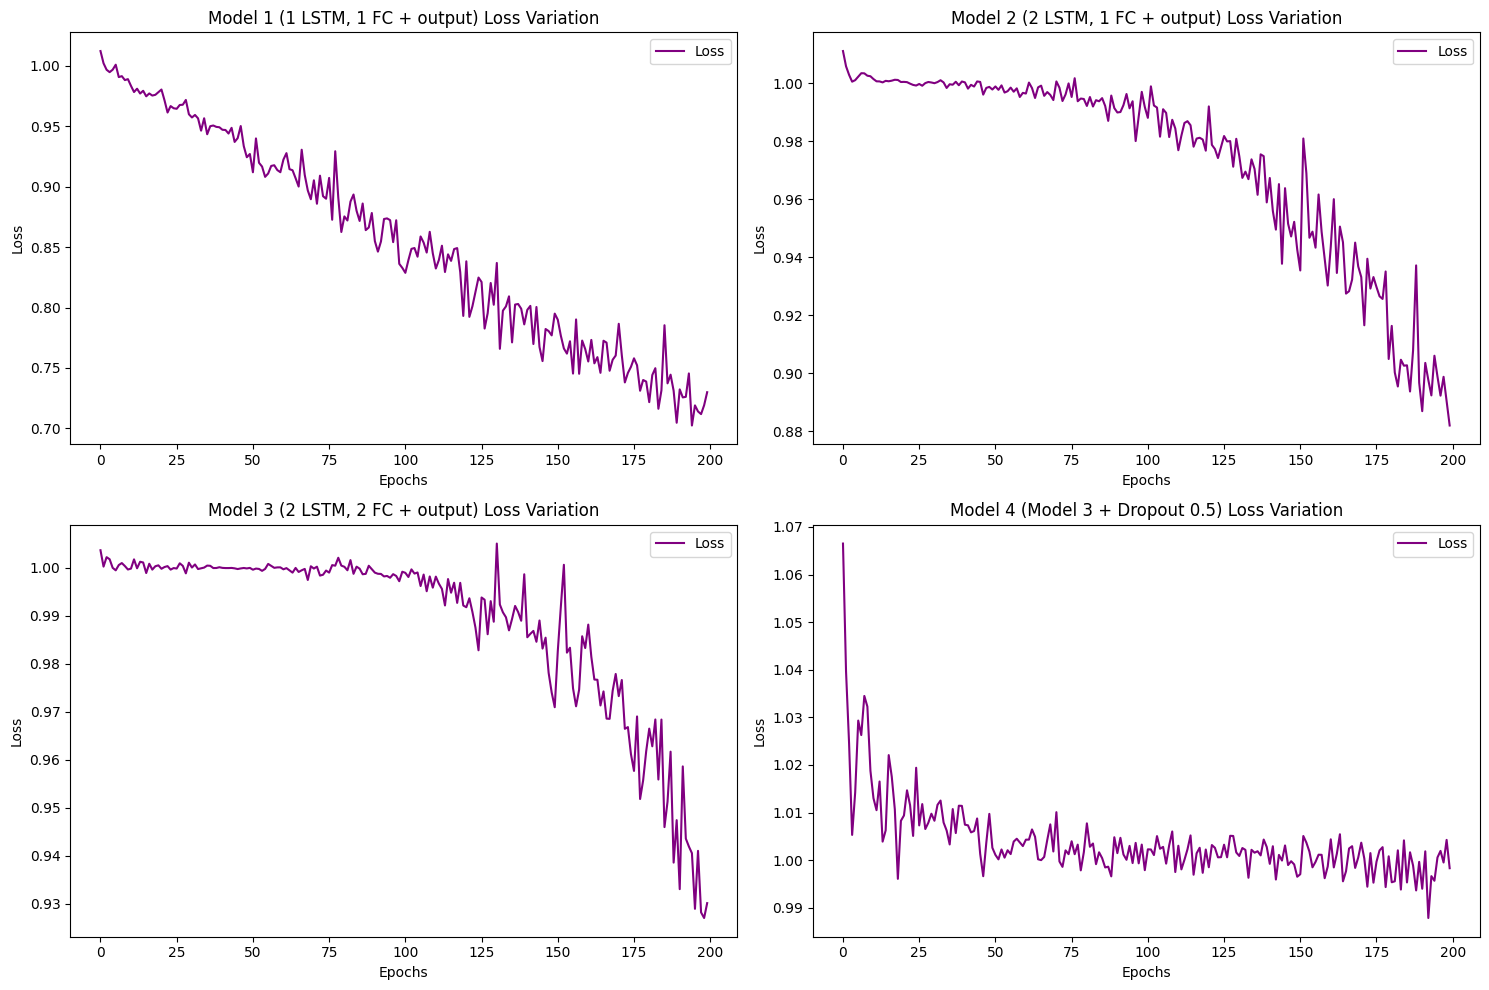

In [60]:
# -------------------------------
# Plot Loss Variation for Each Model
# -------------------------------
plt.figure(figsize=(15, 10))
for i, (name, loss_values) in enumerate(losses_dict.items()):
    plt.subplot(2, 2, i + 1)
    plt.plot(loss_values, label='Loss', color='purple')
    plt.title(f"{name} Loss Variation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
plt.tight_layout()
plt.show()


In [61]:
! pip install mlflow

In [62]:
# -------------------------------
# MLFlow Integration: Train & Log Metrics for Each Model
# -------------------------------
import mlflow
import mlflow.pytorch

mlflow.set_experiment("AQI_Prediction_Milestone2_MLOps")

# Hyperparameters
num_epochs = 200
lr = 0.001

for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        # Log basic hyperparameters
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("input_size", input_size)
        mlflow.log_param("num_epochs", num_epochs)
        mlflow.log_param("learning_rate", lr)

        # Depending on the model, log hidden size and layers info
        if "Model 1" in model_name or "Model 2" in model_name:
            mlflow.log_param("hidden_size", hidden_size_m1_m2)
            mlflow.log_param("num_lstm_layers", 1 if "Model 1" in model_name else 2)
        else:
            mlflow.log_param("hidden_size", hidden_size_m3_m4)
            mlflow.log_param("fc_hidden_size", fc_hidden_size)
            mlflow.log_param("num_lstm_layers", 2)
            if "Dropout" in model_name:
                mlflow.log_param("dropout_rate", 0.5)

        # Train the model
        print(f"\nTraining {model_name} ...")
        losses = train_model(model, X_train_tensor, y_train_tensor, num_epochs=num_epochs, lr=lr)
        mlflow.log_metric("final_loss", losses[-1])

        # Save and log the loss curve plot
        plt.figure()
        plt.plot(losses, label="Training Loss", color="purple")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"{model_name} Training Loss")
        plt.legend()
        plt.savefig("loss_curve.png")
        mlflow.log_artifact("loss_curve.png")
        plt.close()

        # Evaluate the model and log evaluation metrics
        r2, mae, rmse, mape, preds_inv, y_actual = evaluate_model(model, X_test_tensor, y_test_tensor)
        mlflow.log_metric("r2_score", r2)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mape", mape)

        print(f"{model_name} Metrics:")
        print(f"R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}%")

        # Plot Actual vs. Predicted AQI and log the plot
        plt.figure(figsize=(10,6))
        plt.plot(y_actual, label="Actual AQI", linestyle="--", color="blue")
        plt.plot(preds_inv, label="Predicted AQI", color="red")
        plt.title(f"{model_name}: Actual vs Predicted AQI")
        plt.xlabel("Test Sample Index")
        plt.ylabel("AQI")
        plt.legend()
        plt.savefig("predictions_plot.png")
        mlflow.log_artifact("predictions_plot.png")
        plt.close()

        # Log the trained model
        mlflow.pytorch.log_model(model, "model")


Training Model 1 (1 LSTM, 1 FC + output) ...
Epoch 20/200 Loss: 0.67306
Epoch 40/200 Loss: 0.70718
Epoch 60/200 Loss: 0.68338
Epoch 80/200 Loss: 0.66880
Epoch 100/200 Loss: 0.61014
Epoch 120/200 Loss: 0.61562
Epoch 140/200 Loss: 0.60165
Epoch 160/200 Loss: 0.60401
Epoch 180/200 Loss: 0.56326
Epoch 200/200 Loss: 0.58354
Model 1 (1 LSTM, 1 FC + output) Metrics:
R²: 0.5503, MAE: 10.3325, RMSE: 13.3989, MAPE: 13.5325%


2025/02/27 09:47:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/02/27 09:47:29 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/02/27 09:47:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training Model 2 (2 LSTM, 1 FC + output) ...
Epoch 20/200 Loss: 0.86134
Epoch 40/200 Loss: 0.83441
Epoch 60/200 Loss: 0.82515
Epoch 80/200 Loss: 0.78971
Epoch 100/200 Loss: 0.77069
Epoch 120/200 Loss: 0.72939
Epoch 140/200 Loss: 0.72684
Epoch 160/200 Loss: 0.70220
Epoch 180/200 Loss: 0.65600
Epoch 200/200 Loss: 0.65403
Model 2 (2 LSTM, 1 FC + output) Metrics:
R²: 0.4134, MAE: 12.0736, RMSE: 15.3036, MAPE: 16.2145%


2025/02/27 09:47:37 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/02/27 09:47:46 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/02/27 09:47:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training Model 3 (2 LSTM, 2 FC + output) ...
Epoch 20/200 Loss: 0.90763
Epoch 40/200 Loss: 0.91350
Epoch 60/200 Loss: 0.87717
Epoch 80/200 Loss: 0.89467
Epoch 100/200 Loss: 0.84305
Epoch 120/200 Loss: 0.82580
Epoch 140/200 Loss: 0.78543
Epoch 160/200 Loss: 0.75811
Epoch 180/200 Loss: 0.72649
Epoch 200/200 Loss: 0.73301
Model 3 (2 LSTM, 2 FC + output) Metrics:
R²: 0.1065, MAE: 15.0691, RMSE: 18.8871, MAPE: 19.6759%


2025/02/27 09:47:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/02/27 09:47:55 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/02/27 09:47:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training Model 4 (Model 3 + Dropout 0.5) ...
Epoch 20/200 Loss: 0.99153
Epoch 40/200 Loss: 0.99011
Epoch 60/200 Loss: 0.99874
Epoch 80/200 Loss: 0.97766
Epoch 100/200 Loss: 0.98376
Epoch 120/200 Loss: 0.97398
Epoch 140/200 Loss: 0.98273
Epoch 160/200 Loss: 0.96925
Epoch 180/200 Loss: 0.95905
Epoch 200/200 Loss: 0.96429
Model 4 (Model 3 + Dropout 0.5) Metrics:
R²: -0.4887, MAE: 20.5466, RMSE: 24.3801, MAPE: 29.8249%


2025/02/27 09:47:58 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/02/27 09:48:05 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/02/27 09:48:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [63]:
!pip install pyngrok

In [66]:
from pyngrok import ngrok
!ngrok authtoken 2tQS3Osnmi3zFJ8YOVe0pK09iFN_6dyBEL1cGVLEiMPmYyPSr

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [67]:
# Launch MLflow UI in the background on port 5000 using nohup
!nohup mlflow ui --port 5000 &

nohup: appending output to 'nohup.out'


In [68]:
# Allow some time for MLflow UI to start
import time
time.sleep(10)

In [69]:
# Set up the ngrok tunnel to port 5000
from pyngrok import ngrok
public_url = ngrok.connect(5000)
print("MLflow UI is accessible at:", public_url)

MLflow UI is accessible at: NgrokTunnel: "https://1bf5-34-73-9-172.ngrok-free.app" -> "http://localhost:5000"
